In [1]:
# slow_example.ipynb
# Authors Stephan Meighen-Berger
# Earth is a vacuum right?

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from numba import njit

In [3]:
# parameters
m2GeV = 1 / (0.197 * 1e-15)
eV2GeV = 1e-9
# mdiff = np.array([1., 7.58e-5, 7.58e-5 + 2.453e-3]) * eV2GeV**2  # GeV  # pdg 12 = 7.53
mdiff = np.array([1., 7.58e-5, 7.58e-5 + 2.453e-3]) * eV2GeV**2

In [4]:
# Basic functions
@njit
def mass_diff_mat(i: int, j: int, matrix: np.array) -> float:
    """ Fetches the mass differences from the mass matrix

    Parameters
    ----------
    i,j: int
        Matter states to compare

    Returns
    -------
    mass_diff: float
        The mass difference squared
    """
    if i == j:
        return 0
    states_ordered = np.sort(np.array([i, j]))  # Need the lowest number to be first
    if states_ordered[0] == 0:
        return matrix[states_ordered[1], states_ordered[1]]
    else:
        return (
            matrix[states_ordered[1], states_ordered[1]] -
            matrix[states_ordered[0], states_ordered[0]]
        )

# oscillation length
def l_osc(i: int, j: int, E: float, mass_matrix: np.matrix) -> float:
    """ The oscillation length for the given flavor combination and energy

    Parameters
    ----------
    i,j: int
        The matter states
    E: float
        The neutrino energy
    mass_matrix: np.matrix
        The mass matrix

    Returns
    -------
    losc: float
        The oscillation length
    """
    return (
        4. * np.pi * E / mass_diff_mat(i, j, mass_matrix)
    )
# coherence length
def l_coherence(i: int, j: int, E: float, sigma: float, mass_matrix: np.matrix) -> float:
    """ The coherence length for the given flavor combination and energy

    Parameters
    ----------
    i,j: int
        The matter states
    E: float
        The neutrino energy
    sigma: float
        positional uncertainty
    mass_matrix: np.matrix
        The mass matrix

    Returns
    -------
    lcoherence: float
        The coherence length
    """
    return (
        4. * np.sqrt(2) * E**2. * sigma / mass_diff_mat(i, j, mass_matrix)
    )

# coherence length matter
def l_coherence_matter(
            flavor: int, i: int, j: int, E: float, sigma: float,
            V: np.matrix, angle: float, mass_matrix: np.matrix
        ) -> float:
    """ The coherence length for the given flavor combination and energy

    Parameters
    ----------
    flavor: int
        The original flavor state
    i,j: int
        The matter states
    E: float
        The neutrino energy
    sigma: float
        positional uncertainty
    V: np.matrix
        The effective potential matrix
    angle: float
        The mixing angle between the states
    mass_matrix: np.matrix
        The mass matrix

    Returns
    -------
    lcoherence_matter: float
        The coherence length in matter
    """
    if angle == 0:
        return 0
    return (
        4. * np.sqrt(2) * E**2. * sigma / V[flavor, flavor] / np.sin(2. * np.sin(np.rad2deg(angle))) / mass_diff_mat(i, j, mass_matrix)
    )

def buildmassmatrix(params: np.array) -> np.array:
    """ constructs the squared mass matrix from the input parameters

    Parameters
    ----------
    params: jax.numpy.array
        Array containing the mass parameters. These should be the orderd
        masses of the eigenstates, with the first value being the lightest mass
        and all others the squared mass difference

    Returns
    -------
    masssqrd: jax.numpy.array
        The squared diagonal mass matrix
    """
    assert -params[0]**2 <= min(params[1:]), "All masses have to be positive!"
    
    return np.diag([params[0]**2] + [params[0]**2 + m for m in params[1:]])

# basis transform
def rotmatrix(dim: int, i: int, j: int, ang: float, cp: float):
    """ constructs a (Gell-Mann) rotational matrix ij with angle ang and cp violating phase cp
    for symmetry i < j is required

    Parameters
    ----------
    dim: int
        Dimensions of the matrix
    i,j: int
        Positions of the matrix
    ang: float
        Angle of roration in radians
    cp: float
        CP violating phase

    Returns
    -------
    rotmat: jax.numpy.array
        The rotation matrix

    Raises
    ------
    DimensionError:
        The input dimensions dim, i, j are wrong
    """
    # Building
    if cp == 0:
        R = np.eye(dim)
        R[i, j] = np.sin(ang)
        R[j, i] = -np.sin(ang)
    else:
        R = np.eye(dim, dtype='complex128')
        R[i, j] = np.sin(ang) * np.exp(-1j * cp)
        R[j, i] = -np.sin(ang) * np.exp(1j * cp)
    R[i, i] = R[j, j] = np.cos(ang)
    return R

def buildmixingmatrix(params: np.ndarray) -> np.ndarray:
    """ constructs the mixing matrix from the input parameters
    for symmetry i < j is required

    For CP-violating factors, use tuples like (i,j,theta_ij,delta_ij),
    with delta_ij in degrees.

    Parameters
    ----------
    params: jax.numpy.array
        tuples descriping the mixing matrix.
        The format of each tuple should be [i, j, theta_ij]

    Returns
    -------
    mixing_matrix: jax.numpy.array
        The mixing matrix constructed in revers order.
        E.g. params = [(1,2,33.89),(1,3,9.12),(2,3,45.00)]
        => U = R_23 . R_13 . R_12
    """
    dim = max(np.array([par[1] for par in params]))
    U = np.eye(dim)
    # Applying the rotation matrices
    for par in params:
        if len(par) > 3:
            U = np.dot(rotmatrix(dim, par[0] - 1, par[1] - 1, np.deg2rad(par[2]), np.deg2rad(par[3])), U)
        else:
            U = np.dot(rotmatrix(dim, par[0] - 1, par[1] - 1, np.deg2rad(par[2]) , 0), U)
    return U

In [5]:
# Transition probability using plane waves
# Following arXiv:1206.0812v1
def wp_prob(
        alpha: int, beta: int, E: float, L: float,
        sigma: float, mixing_angles: np.ndarray, mass_states=3, matter=None
    ):
    """ Oscillation probability using a WP approach. This is a modified version of the calculations
    shown in arXiv:1206.0812v1.

    Parameters
    ----------
    alpha: int
        Flavor state oscillating from
    beta: int
        Flavor state to oscillate to
    E: float
        Energy of the oscillating neutrino
    L: float
        Travel distance in km
    sigam: float
        Uncertainties of the system (positional)
        Specifically sigma**2 = sigma_inital**2 + sigma_final**2
        Units cm
    mixing_angles: np.array
        Mixing angles between the matter and flavor states (PMNS matrix)
    mass_states: int
        Optional: Number of mass states, this should agree with the mixing matrix
    matter: np.ndarray
        Optional: Effective potential in matrix form induced by the ambient matter

    Returns
    -------
    oscillation_prob: float
        The oscillation probability
    """
    mixing_matrix = buildmixingmatrix(mixing_angles)
    first  = 0
    l_tmp = L * 1e3 * m2GeV
    sigma_tmp = sigma * 1e-2 * m2GeV
    # need to create the effective hamiltonian and diagonalize
    mass_matrix = np.matrix(buildmassmatrix(mdiff))
    mixing_matrix = np.matrix(mixing_matrix)
    if matter is None:
        U = mixing_matrix
        H = mass_matrix
        # effective_h = mixing_matrix * mass_matrix * mixing_matrix.H
        # U, H, _ = np.linalg.svd(effective_h)
        # n = len(H)
        # H = H[::-1]
        # H = np.matrix(np.diag(H))
        # # re-ordering
        # U[:, :n] = U[:, n-1::-1]
    else:
        effective_h = mixing_matrix * mass_matrix * mixing_matrix.H + matter
        U, H, _ = np.linalg.svd(effective_h) # Output in descending order for H
        n = len(H)
        H = np.matrix(np.diag(H[::-1]))  # Sorts in decending order 
        U[:, :n] = U[:, n-1::-1]
    for j in range(mass_states):
        # First term
        first += (np.abs(U[alpha, j])**2) * (np.abs(U[beta, j])**2)
        second = 0
        for i in range(j):
            losc = l_osc(j, i, E, H)
            if sigma_tmp != 0:
                # Assuming symmetric
                ordered_flavors = np.sort([alpha, beta])
                for ang in mixing_angles:
                    if ordered_flavors[0] + 1 == ang[0]:
                        if ordered_flavors[0] + 1 == ang[1]:
                            angle = ang[2]
                    else:
                        angle = 0
                if ((matter is None) or (angle == 0)):
                    second += (
                        U[alpha, i] * np.conj(U[alpha, j]) *
                        np.conj(U[beta, i]) * U[beta, j] *
                        np.exp(
                            -2*np.pi*1j * l_tmp / losc - (l_tmp / l_coherence(j, i, E, sigma_tmp, H))**2. -
                            2. * np.pi**2. * (sigma_tmp / losc)**2.
                        )
                    )
                else:
                    second += (
                        U[alpha, i] * np.conj(U[alpha, j]) *
                        np.conj(U[beta, i]) * U[beta, j] *
                        np.exp(
                            -2*np.pi*1j * l_tmp / losc - (l_tmp / l_coherence(j, i, E, sigma_tmp, H))**2. -
                            2. * np.pi**2. * (sigma_tmp / losc)**2. + (2*l_tmp / l_coherence_matter(alpha, j, i, E, sigma_tmp, matter, angle, H))**2.
                        )
                    )
            else:
                second += (
                    U[alpha, i] * np.conj(U[alpha, j]) *
                    np.conj(U[beta, i]) * U[beta, j] *
                    np.exp(
                        -2*np.pi*1j * l_tmp / losc
                    )
                )
        second = np.real(second)
        first += 2*second  
    return first

In [6]:
# air_pot = 1.225 * 1e-3 * 3.8 * 1e-14 / 2. * 7 * 1e-9  # 7 from nitrogen
earth_pot = 1.65 * 1e-22
uncertainty_x = 0 # in cm
rEarth = 6371  # in km
# Mixing angles pdg
mixing_angles = np.array([
    [1, 2, np.arcsin(np.sqrt(0.312)) / np.pi * 180.],
    [1, 3, np.arcsin(np.sqrt(0.025)) / np.pi * 180., 0],  #  add cp violation here
    [2, 3, np.arcsin(np.sqrt(0.420)) / np.pi * 180.],
], dtype=object)
mdiff = np.array([1, 7.60e-5, 7.60e-5 + 2.35e-3]) * eV2GeV**2 # mdiff = np.array([1., 7.58e-5, 7.58e-5 + 2.453e-3]) * eV2GeV**2

In [7]:
cosZ = np.linspace(-1, 1., 400)
e_grid = np.logspace(-1, 0, 1000)
uncertainties = [0]
ratmos = 20 + rEarth  # in km

In [8]:
results_mu = []
for uncertainty_x in uncertainties:
    uncert_tmp = []
    for zenith in tqdm(np.arccos(cosZ)):
        distance = np.sqrt(ratmos*ratmos + rEarth*rEarth - 2*ratmos*rEarth*np.cos(zenith - np.arcsin(np.sin(np.pi-zenith)/ratmos*rEarth) ) )
        org_flavor = 0
        def wp_1_tmp(E):
            return (
                wp_prob(org_flavor, 0, E, distance, uncertainty_x, mixing_angles, mass_states=3, matter=None)
            )
        def wp_2_tmp(E):
            return (
                wp_prob(org_flavor, 1, E, distance, uncertainty_x, mixing_angles, mass_states=3, matter=None)
            )
        def wp_3_tmp(E):
            return (
                wp_prob(org_flavor, 2, E, distance, uncertainty_x, mixing_angles, mass_states=3, matter=None)
            )
        def prob_mapper(e_grid, workers=8):
            with Pool(processes=workers) as pool:
                probs_1 = np.array(
                    pool.map(wp_1_tmp, e_grid)
                )
                probs_2 = np.array(
                    pool.map(wp_2_tmp, e_grid)
                )
                probs_3 = np.array(
                    pool.map(wp_3_tmp, e_grid)
                )
            return probs_1, probs_2, probs_3
        probs_1, probs_2, probs_3 = prob_mapper(e_grid)
        uncert_tmp.append([probs_1, probs_2, probs_3])
    results_mu.append(uncert_tmp)    
results_mu = np.array(results_mu)

  9%|▉         | 37/400 [02:49<27:39,  4.57s/it]


KeyboardInterrupt: 

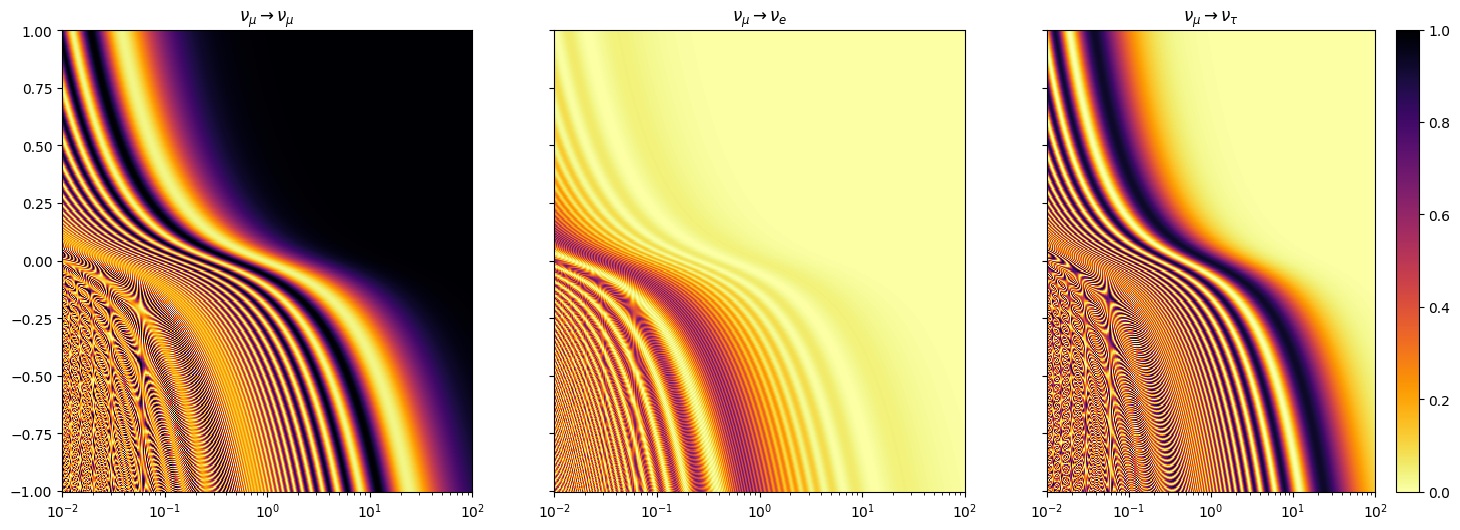

In [ ]:
uncertainty_id = 0
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
mu_mu = np.array([
    res[1] for res in results_mu[uncertainty_id]
])
mu_e = np.array([
    res[0] for res in results_mu[uncertainty_id]
])
mu_tau = np.array([
    res[2] for res in results_mu[uncertainty_id]
])
Xfine, Yfine = np.meshgrid(e_grid, cosZ)
axs[0].pcolor(Xfine, Yfine, mu_mu, cmap='inferno_r', vmin=0., vmax=1.)
axs[0].set_xscale('log')
axs[0].set_xlim(1e-1, 1e0)
axs[0].set_title(r'$\nu_e\rightarrow\nu_\mu$')
axs[1].pcolor(Xfine, Yfine, mu_e, cmap='inferno_r', vmin=0., vmax=1.)
axs[1].set_xscale('log')
axs[1].set_xlim(1e-1, 1e0)
axs[1].set_title(r'$\nu_e\rightarrow\nu_e$')
pc = axs[2].pcolor(Xfine, Yfine, mu_tau, cmap='inferno_r', vmin=0., vmax=1.)
axs[2].set_xscale('log')
axs[2].set_xlim(1e-1, 1e0)
axs[2].set_title(r'$\nu_e\rightarrow\nu_\tau$')
plt.colorbar(pc)
# plt.savefig('../pics/fine_osci_analytical.png', dpi=250)